# Задание
Данные берем отызывы за лето
На вебинаре мы говорили, что долгое время CNN и RNN архитектуры были конурируещими выяснить какая архитектура больше подходит для нашей задачи 
1. построить свёрточные архитектуры 
2. построить различные архитектуры с RNN
3. построить совместные архитектуры CNN -> RNN или (RNN -> CNN)

In [30]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, GlobalMaxPool2D, SimpleRNN, LSTM, GRU, Masking, Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard 
# from keras.objectives import categorical_crossentropy
from keras.callbacks import EarlyStopping  
from keras.utils import np_utils

In [2]:
df = pd.read_excel('отзывы за лето.xls')

#### Предобработка

In [3]:
df = df.dropna()

In [4]:
df.loc[:, 'Content'] = df['Content'].astype(str)

In [5]:
X = df['Content']
y = df['Rating']

In [6]:
num_classes = 1

# Training
epochs = 20
batch_size = 512

In [7]:
y = np.where(y == 5, 1, 0) # Классификация по отлично/не отлично

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
text_corpus_train = X_train
text_corpus_test = X_test

In [10]:
tokenizer = Tokenizer(num_words=None, 
                     filters='#$%&()*+-<=>@[\\]^_`{|}~\t\n',
                     lower = False, split = ' ')
tokenizer.fit_on_texts(text_corpus_train)

sequences_train = tokenizer.texts_to_sequences(text_corpus_train)
sequences_test = tokenizer.texts_to_sequences(text_corpus_test)

word_count = len(tokenizer.index_word) + 1
training_length = max([len(i.split()) for i in text_corpus_train])

X_train = pad_sequences(sequences_train, maxlen=training_length)
X_test = pad_sequences(sequences_test, maxlen=training_length)

In [11]:
max_words = word_count
max_len = training_length

#### CNN

In [12]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(10))
model.add(Activation("relu"))
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

In [13]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [14]:
tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard, early_stopping])

Epoch 1/20
30/30 [==============================] - 6s 186ms/step - loss: 0.5777 - accuracy: 0.7062 - val_loss: 0.4745 - val_accuracy: 0.7737
Epoch 2/20
30/30 [==============================] - 6s 204ms/step - loss: 0.4052 - accuracy: 0.8405 - val_loss: 0.3322 - val_accuracy: 0.8748


In [15]:
from sklearn.metrics import classification_report

In [16]:
preds_proba = model.predict(X_test)
preds = [np.round(l) for l in preds_proba]
print(classification_report([np.round(l) for l in y_test], preds))

              precision    recall  f1-score   support

           0       0.78      0.72      0.75      1204
           1       0.89      0.92      0.90      2928

    accuracy                           0.86      4132
   macro avg       0.84      0.82      0.83      4132
weighted avg       0.86      0.86      0.86      4132



#### RNN

In [17]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))

model.add(SimpleRNN(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [18]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [19]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard, early_stopping])

Epoch 1/20
30/30 [==============================] - 7s 200ms/step - loss: 0.6014 - accuracy: 0.6772 - val_loss: 0.4645 - val_accuracy: 0.7937
Epoch 2/20
30/30 [==============================] - 6s 191ms/step - loss: 0.4572 - accuracy: 0.8070 - val_loss: 0.3944 - val_accuracy: 0.8445


In [20]:
preds_proba = model.predict(X_test)
preds = [np.round(l) for l in preds_proba]
print(classification_report([np.round(l) for l in y_test], preds))

              precision    recall  f1-score   support

           0       0.72      0.56      0.63      1204
           1       0.83      0.91      0.87      2928

    accuracy                           0.81      4132
   macro avg       0.78      0.73      0.75      4132
weighted avg       0.80      0.81      0.80      4132



#### CNN+RNN

In [21]:
from keras.utils.vis_utils import plot_model

In [22]:
# !pip install pydot
# !pip install pydotplus
# !pip install graphviz
# brew install graphviz

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 176, 128)          3158784   
                                                                 
 conv1d_3 (Conv1D)           (None, 174, 128)          49280     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_7 (Dense)             (None, 10)                1290      
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                                                 
Total params: 3,209,365
Trainable params: 3,209,365
Non-trainable params: 0
____________________________________________

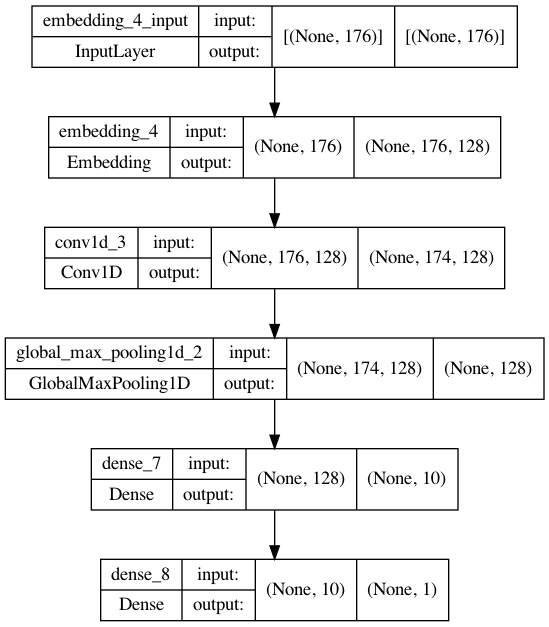

In [26]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(Conv1D(128, 3, activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(num_classes, activation='sigmoid'))

model.build()

print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 176, 30)           740340    
                                                                 
 masking_2 (Masking)         (None, 176, 30)           0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 64)                6080      
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 750,645
Trainable params: 750,645
Non-tr

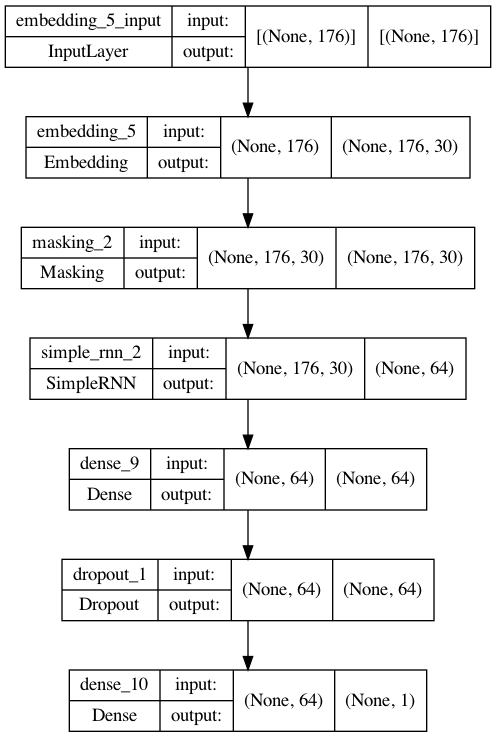

In [27]:
model = Sequential()
model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))

model.add(SimpleRNN(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.build()

print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 176, 128)          3158784   
                                                                 
 masking_9 (Masking)         (None, 176, 128)          0         
                                                                 
 conv1d_10 (Conv1D)          (None, 174, 128)          49280     
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dense_11 (Dense)            (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 1)               

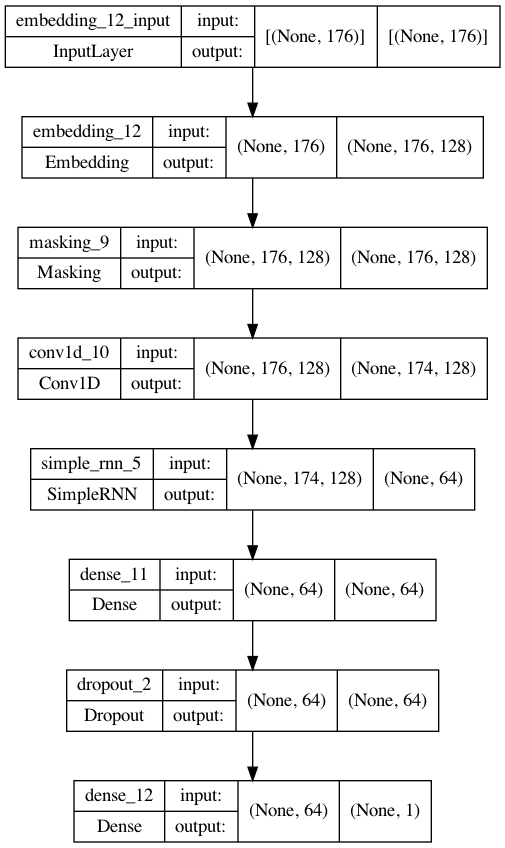

In [37]:
model = Sequential()
model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=128,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))

model.add(Conv1D(128, 3, activation='relu'))
model.add(SimpleRNN(64))
# model.add(GlobalMaxPool1D())
# model.add(Dense(10, activation='relu'))
# model.add(Dense(num_classes, activation='sigmoid'))
# model.add(SimpleRNN(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.build()

print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True)

In [39]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard, early_stopping])

preds_proba = model.predict(X_test)
preds = [np.round(l) for l in preds_proba]
print(classification_report([np.round(l) for l in y_test], preds))

Epoch 1/20
30/30 [==============================] - 13s 401ms/step - loss: 0.2881 - accuracy: 0.9020 - val_loss: 0.3390 - val_accuracy: 0.8796
Epoch 2/20
30/30 [==============================] - 13s 426ms/step - loss: 0.1988 - accuracy: 0.9377 - val_loss: 0.3830 - val_accuracy: 0.8657
              precision    recall  f1-score   support

           0       0.81      0.65      0.72      1204
           1       0.87      0.94      0.90      2928

    accuracy                           0.85      4132
   macro avg       0.84      0.79      0.81      4132
weighted avg       0.85      0.85      0.85      4132



Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 176, 128)          3158784   
                                                                 
 masking_14 (Masking)        (None, 176, 128)          0         
                                                                 
 conv1d_15 (Conv1D)          (None, 174, 128)          49280     
                                                                 
 global_max_pooling1d_8 (Glo  (None, 1, 128)           0         
 balMaxPooling1D)                                                
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                     

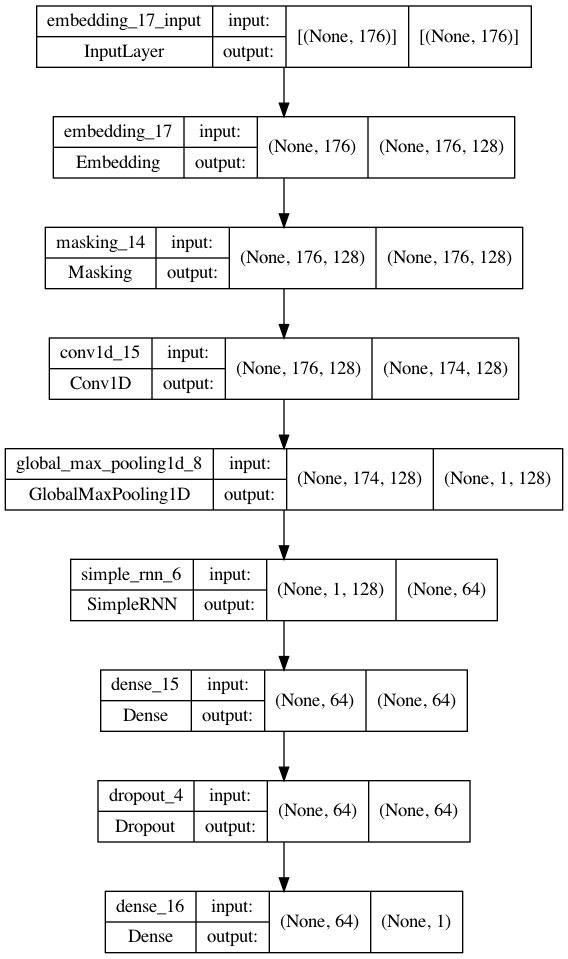

In [45]:
model = Sequential()
model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=128,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))

model.add(Conv1D(128, 3, activation='relu'))
model.add(GlobalMaxPool1D(keepdims=True))
model.add(SimpleRNN(64))
# model.add(Dense(10, activation='relu'))
# model.add(Dense(num_classes, activation='sigmoid'))
# model.add(SimpleRNN(64))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.build()

print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True)

In [46]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard, early_stopping])

preds_proba = model.predict(X_test)
preds = [np.round(l) for l in preds_proba]
print(classification_report([np.round(l) for l in y_test], preds))

Epoch 1/20
30/30 [==============================] - 7s 201ms/step - loss: 0.5529 - accuracy: 0.7406 - val_loss: 0.3722 - val_accuracy: 0.8560
Epoch 2/20
30/30 [==============================] - 6s 210ms/step - loss: 0.3521 - accuracy: 0.8703 - val_loss: 0.3120 - val_accuracy: 0.8875
              precision    recall  f1-score   support

           0       0.83      0.69      0.75      1204
           1       0.88      0.94      0.91      2928

    accuracy                           0.87      4132
   macro avg       0.85      0.81      0.83      4132
weighted avg       0.86      0.87      0.86      4132



#### CNN+MaxPool+RNN пока дали наивысшую метрику, чуть выше чем без RNN

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 176, 128)          3158784   
                                                                 
 masking_16 (Masking)        (None, 176, 128)          0         
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 176, 128)          32896     
                                                                 
 conv1d_16 (Conv1D)          (None, 174, 128)          49280     
                                                                 
 global_max_pooling1d_9 (Glo  (None, 1, 128)           0         
 balMaxPooling1D)                                                
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 64)                12352     
                                                     

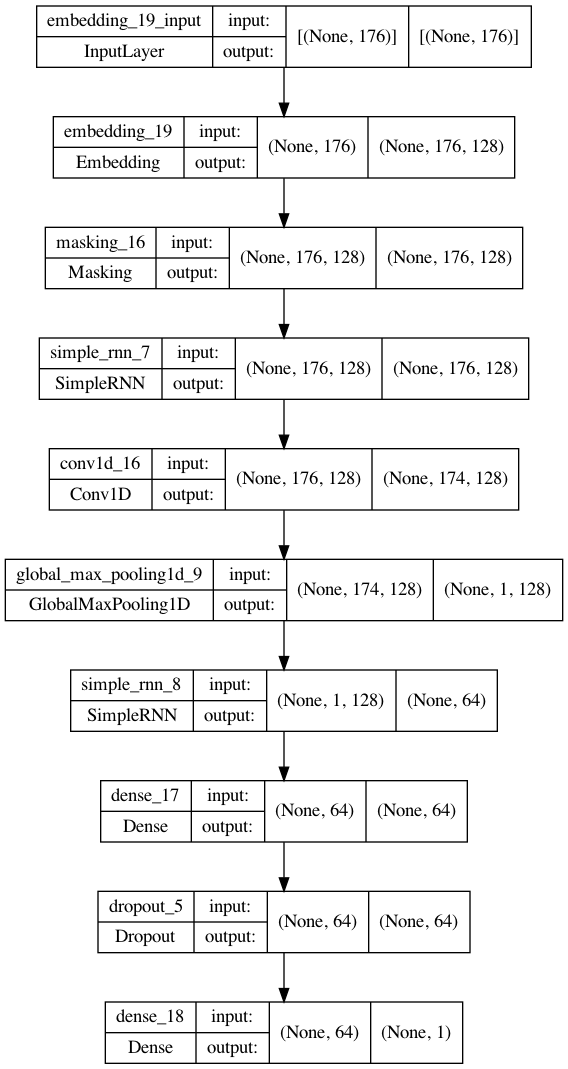

In [48]:
model = Sequential()
model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=128,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))

model.add(SimpleRNN(128, return_sequences=True)) # return_sequences Сохраняет размерность для Conv1D
model.add(Conv1D(128, 3, activation='relu'))
model.add(GlobalMaxPool1D(keepdims=True)) # keepdims Сохраняет размерность для SimpleRNN
model.add(SimpleRNN(64))

# model.add(Dense(10, activation='relu'))
# model.add(Dense(num_classes, activation='sigmoid'))
# model.add(SimpleRNN(64))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.build()

print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True)

In [49]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard, early_stopping])

preds_proba = model.predict(X_test)
preds = [np.round(l) for l in preds_proba]
print(classification_report([np.round(l) for l in y_test], preds))

Epoch 1/20
30/30 [==============================] - 20s 605ms/step - loss: 0.5102 - accuracy: 0.7716 - val_loss: 0.4039 - val_accuracy: 0.8421
Epoch 2/20
30/30 [==============================] - 19s 637ms/step - loss: 0.3727 - accuracy: 0.8630 - val_loss: 0.4794 - val_accuracy: 0.8342
              precision    recall  f1-score   support

           0       0.67      0.83      0.74      1204
           1       0.92      0.83      0.87      2928

    accuracy                           0.83      4132
   macro avg       0.80      0.83      0.81      4132
weighted avg       0.85      0.83      0.84      4132



#### RNN+CNN+RNN Ухудшили результат

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 176, 128)          3158784   
                                                                 
 masking_28 (Masking)        (None, 176, 128)          0         
                                                                 
 conv1d_37 (Conv1D)          (None, 174, 128)          49280     
                                                                 
 simple_rnn_22 (SimpleRNN)   (None, 174, 128)          32896     
                                                                 
 conv1d_38 (Conv1D)          (None, 172, 64)           24640     
                                                                 
 simple_rnn_23 (SimpleRNN)   (None, 172, 64)           8256      
                                                                 
 conv1d_39 (Conv1D)          (None, 171, 32)         

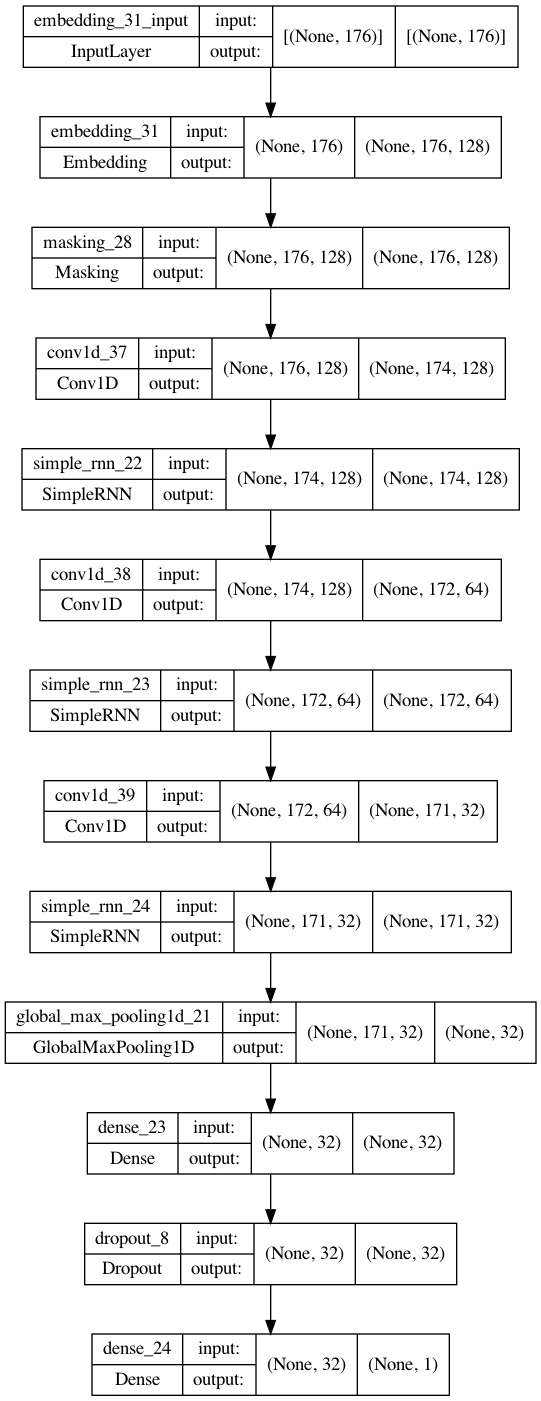

In [61]:
model = Sequential()
model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=128,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))
model.add(Conv1D(128, 3, activation='relu'))
model.add(SimpleRNN(128, return_sequences=True)) # return_sequences Сохраняет размерность для Conv1D
model.add(Conv1D(64, 3, activation='relu'))
model.add(SimpleRNN(64, return_sequences=True)) # return_sequences Сохраняет размерность для Conv1D
model.add(Conv1D(32, 2, activation='relu'))
model.add(SimpleRNN(32, return_sequences=True)) # return_sequences Сохраняет размерность для Conv1D
model.add(GlobalMaxPool1D())
# model.add(Conv1D(128, 3, activation='relu'))
# model.add(GlobalMaxPool1D(keepdims=True)) # keepdims Сохраняет размерность для SimpleRNN
# model.add(SimpleRNN(64, return_sequences=True)) # return_sequences Сохраняет размерность для Conv1D
# model.add(Conv1D(32, 2, activation='relu'))
# model.add(GlobalMaxPool1D())

# model.add(Dense(10, activation='relu'))
# model.add(Dense(num_classes, activation='sigmoid'))
# model.add(SimpleRNN(64))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.build()

print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True)

In [62]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard, early_stopping])

preds_proba = model.predict(X_test)
preds = [np.round(l) for l in preds_proba]
print(classification_report([np.round(l) for l in y_test], preds))

Epoch 1/20
30/30 [==============================] - 29s 897ms/step - loss: 0.6263 - accuracy: 0.6632 - val_loss: 0.4595 - val_accuracy: 0.8173
Epoch 2/20
30/30 [==============================] - 29s 983ms/step - loss: 0.4714 - accuracy: 0.8059 - val_loss: 0.3971 - val_accuracy: 0.8433
              precision    recall  f1-score   support

           0       0.79      0.50      0.61      1204
           1       0.82      0.94      0.88      2928

    accuracy                           0.82      4132
   macro avg       0.80      0.72      0.75      4132
weighted avg       0.81      0.82      0.80      4132



#### Комбинация из трёх CNN+RNN сильно повысило время обучения и ухудшило метрику. Вывод: наращивание слоёв копипастой не работает.

In [63]:
model = Sequential()
model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=128,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))

model.add(Conv1D(128, 3, activation='relu'))
model.add(GlobalMaxPool1D(keepdims=True))
model.add(LSTM(64))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard, early_stopping])

preds_proba = model.predict(X_test)
preds = [np.round(l) for l in preds_proba]
print(classification_report([np.round(l) for l in y_test], preds))

Epoch 1/20
30/30 [==============================] - 8s 206ms/step - loss: 0.6171 - accuracy: 0.6955 - val_loss: 0.4987 - val_accuracy: 0.7247
Epoch 2/20
30/30 [==============================] - 7s 236ms/step - loss: 0.4059 - accuracy: 0.8352 - val_loss: 0.3208 - val_accuracy: 0.8820
              precision    recall  f1-score   support

           0       0.80      0.71      0.75      1204
           1       0.89      0.93      0.91      2928

    accuracy                           0.86      4132
   macro avg       0.85      0.82      0.83      4132
weighted avg       0.86      0.86      0.86      4132



In [64]:
model = Sequential()
model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=128,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))

model.add(Conv1D(128, 3, activation='relu'))
model.add(GlobalMaxPool1D(keepdims=True))
model.add(GRU(64))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard, early_stopping])

preds_proba = model.predict(X_test)
preds = [np.round(l) for l in preds_proba]
print(classification_report([np.round(l) for l in y_test], preds))

Epoch 1/20
30/30 [==============================] - 8s 206ms/step - loss: 0.5834 - accuracy: 0.7180 - val_loss: 0.4142 - val_accuracy: 0.8391
Epoch 2/20
30/30 [==============================] - 6s 210ms/step - loss: 0.3667 - accuracy: 0.8627 - val_loss: 0.3132 - val_accuracy: 0.8881
              precision    recall  f1-score   support

           0       0.81      0.74      0.77      1204
           1       0.90      0.93      0.91      2928

    accuracy                           0.87      4132
   macro avg       0.85      0.83      0.84      4132
weighted avg       0.87      0.87      0.87      4132



#### CNN+GRU повысили f1-score на нулевом классе 

In [67]:
model = Sequential()
model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=128,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))

model.add(Conv1D(32, 4, 8, activation='relu'))
model.add(Dropout(0.5))
model.add(GlobalMaxPool1D(keepdims=True))
model.add(LSTM(32))

model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard, early_stopping])

preds_proba = model.predict(X_test)
preds = [np.round(l) for l in preds_proba]
print(classification_report([np.round(l) for l in y_test], preds))

Epoch 1/20
30/30 [==============================] - 4s 88ms/step - loss: 0.6707 - accuracy: 0.6814 - val_loss: 0.6420 - val_accuracy: 0.7157
Epoch 2/20
30/30 [==============================] - 2s 76ms/step - loss: 0.5537 - accuracy: 0.7312 - val_loss: 0.4971 - val_accuracy: 0.8288
              precision    recall  f1-score   support

           0       0.69      0.60      0.64      1204
           1       0.84      0.89      0.87      2928

    accuracy                           0.80      4132
   macro avg       0.77      0.74      0.75      4132
weighted avg       0.80      0.80      0.80      4132



#### Пример архитектуры, найденный в интернете, не повысил метрику.

### Вывод: В данном примере добиться повышения метрик от комбинации CNN+RNN практически не удалось.
CNN+GRU слегка повысили f1-score, по сравнению с просто CNN.
0.77/0.91 против 0.75/0.90

Скорее всего, требуется более продуманная предобработка текста, с подгоном под определённую связку CNN/RNN и работа с гиперпараметрами.